In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
import os
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
# import cv2
from google.colab.patches import cv2_imshow

import time

In [9]:
# Initialize the random number generator
import random
random.seed(10)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
tf.__version__

'2.9.2'

# **PART - B**

## **1. Read/import images from folder ‘training_images’.**

In [10]:
images_zip_path = './training_images-20211126T092819Z-001.zip'

In [11]:
with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [12]:
dir = z.filelist[0].filename.split("/")[0] 
dir

'training_images'

In [13]:
os.listdir(dir)

['real_00947.jpg',
 'real_01052.jpg',
 'real_01042.jpg',
 'real_00964.jpg',
 'real_01053.jpg',
 'real_00971.jpg',
 'real_01057.jpg',
 'real_01044.jpg',
 'real_01041.jpg',
 'real_01067.jpg',
 'real_00969.jpg',
 'real_00956.jpg',
 'real_00975.jpg',
 'real_01021.jpg',
 'real_00945.jpg',
 'real_01068.jpg',
 'real_01062.jpg',
 'real_01016.jpg',
 'real_01065.jpg',
 'real_01027.jpg',
 'real_00961.jpg',
 'real_01014.jpg',
 'real_01010.jpg',
 'real_00952.jpg',
 'real_00951.jpg',
 'real_00981.jpg',
 'real_01050.jpg',
 'real_00962.jpg',
 'real_00995.jpg',
 'real_01056.jpg',
 'real_00977.jpg',
 'real_00985.jpg',
 'real_01005.jpg',
 'real_01031.jpg',
 'real_01008.jpg',
 'real_01073.jpg',
 'real_00978.jpg',
 'real_01077.jpg',
 'real_00984.jpg',
 'real_01032.jpg',
 'real_00943.jpg',
 'real_01015.jpg',
 'real_00970.jpg',
 'real_01037.jpg',
 'real_01080.jpg',
 'real_00954.jpg',
 'real_00967.jpg',
 'real_01047.jpg',
 'real_01039.jpg',
 'real_01006.jpg',
 'real_01075.jpg',
 'real_01017.jpg',
 'real_01079

In [14]:
# get all the image's paths from training_images folder
img_file_path = [os.path.join(dir,i) for i in os.listdir(dir)]

In [15]:
img_file_path

['training_images/real_00947.jpg',
 'training_images/real_01052.jpg',
 'training_images/real_01042.jpg',
 'training_images/real_00964.jpg',
 'training_images/real_01053.jpg',
 'training_images/real_00971.jpg',
 'training_images/real_01057.jpg',
 'training_images/real_01044.jpg',
 'training_images/real_01041.jpg',
 'training_images/real_01067.jpg',
 'training_images/real_00969.jpg',
 'training_images/real_00956.jpg',
 'training_images/real_00975.jpg',
 'training_images/real_01021.jpg',
 'training_images/real_00945.jpg',
 'training_images/real_01068.jpg',
 'training_images/real_01062.jpg',
 'training_images/real_01016.jpg',
 'training_images/real_01065.jpg',
 'training_images/real_01027.jpg',
 'training_images/real_00961.jpg',
 'training_images/real_01014.jpg',
 'training_images/real_01010.jpg',
 'training_images/real_00952.jpg',
 'training_images/real_00951.jpg',
 'training_images/real_00981.jpg',
 'training_images/real_01050.jpg',
 'training_images/real_00962.jpg',
 'training_images/re

## **2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.**

In [16]:
img_list = []
for images in img_file_path:
  test_img = cv2.imread(images)
  img_list.append(test_img)
img_list = np.array(img_list)
print(img_list.shape)

(1091, 600, 600, 3)


## **3. From the same loop above, extract metadata of the faces and write into a DataFrame.**

In [17]:
# download haarcascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [18]:
# Create a dataframe to store image box coordinates
faces_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])

In [19]:
%%time

# Detect the faces present in all the images
# Extract metadata from the faces in the same loop and store it in the dataframe
haar_unrecognized_images = []
haar_recognized_images = []

for imgs, img_names in zip(img_list,img_file_path):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_unrecognized_images.append(img_names) 
    temp = {'x':0, 'y':0, 'w':-1, 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':img_names} 
  else:
    haar_recognized_images.append(img_names)
    for (x, y, w, h) in faces:
      temp = {'x':x, 'y':y, 'w':w, 'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':img_names}
      faces_df = faces_df.append(temp,ignore_index=True)
      cv2.rectangle(imgs, (x, y), (x+w, y+h), (255, 0, 0), 2)
print("Detected faces for %s images" % len(haar_recognized_images))
print("Failed to detect faces for %s images" % len(haar_unrecognized_images))

Detected faces for 930 images
Failed to detect faces for 161 images
CPU times: user 6min 23s, sys: 3.37 s, total: 6min 26s
Wall time: 3min 32s


training_images/real_00964.jpg


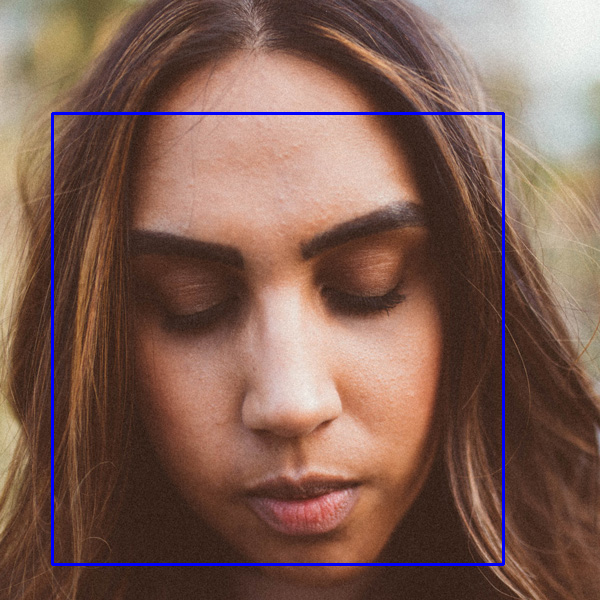

In [20]:
# %%time

print(img_file_path[3])
cv2_imshow(img_list[3])

In [21]:
faces_df

,x,y,w,h,Total_Faces,Image_Name
0,522,138,66,66,1,training_images/real_00947.jpg
1,45,136,396,396,1,training_images/real_01042.jpg
2,52,113,451,451,1,training_images/real_00964.jpg
3,68,50,471,471,1,training_images/real_01053.jpg
4,113,156,398,398,1,training_images/real_01057.jpg
...,...,...,...,...,...,...
1006,120,179,374,374,1,training_images/real_00131.jpg
1007,89,103,452,452,1,training_images/real_00394.jpg
1008,82,131,397,397,1,training_images/real_00125.jpg
1009,65,95,459,459,1,training_images/real_00134.jpg


## **4. Save the output Dataframe in .csv format.**

In [22]:
faces_df.to_csv('faces.csv',index=False)

# **Part C**

## **1. Unzip, read and Load data(‘PINS.zip’) into session.**

In [23]:
# Unzip, read and Load data(‘PINS.zip’) into session
with ZipFile('PINS.zip', 'r') as zf:
  zf.extractall()

## **2. Write function to create metadata of the image.**

In [24]:
# Write function to create metadata of the image
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

## **3. Write a loop to iterate through each and every image and create metadata for all the images.**

In [25]:
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

In [26]:
%%time

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

CPU times: user 68.2 ms, sys: 10.4 ms, total: 78.5 ms
Wall time: 307 ms


In [27]:
metadata[0]

PINS/pins_mark zuckerberg/mark zuckerberg1.jpg

In [28]:
def load_image(path):
    img = cv2.imread(path, 1)
    # function to read image using opencv and convert it from BGR to RGB
    return img[...,::-1]

In [29]:
img = load_image(metadata[0].image_path())

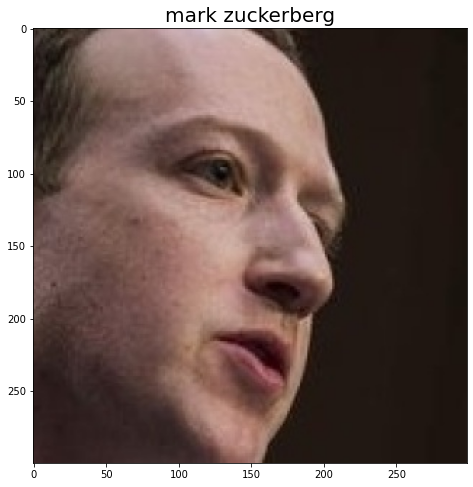

In [30]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 1, 1)
title = labels[0].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

## **4. Generate Embeddings vectors on the each face in the dataset.**

In [31]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [32]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [33]:
vgg_model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [34]:
# Inputs and outputs of vgg face descriptor
vgg_model.inputs, vgg_model.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [35]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_model model and print the shape 
embedding_vector = vgg_model.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [36]:
print('total images::', len(metadata))# Visualising the embedding vector

total images:: 10770


In [37]:
%%time

# Generating embeddings
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_model.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 609ms/step
CPU times: user 3h 23min 56s, sys: 2min 11s, total: 3h 26min 7s
Wall time: 2h 7min 51s


In [68]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


In [69]:
pd.DataFrame(embeddings).to_csv('embeddings.csv',index=False)

## **5. Build distance metrics for identifying the distance between two similar and dissimilar images.**

In [39]:
def distance_metric(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [40]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance_metric(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));   

image_path for index: 1 -  PINS/pins_mark zuckerberg/mark zuckerberg50.jpg
image_path for index: 4 -  PINS/pins_mark zuckerberg/mark zuckerberg51.jpg
image_path for index: 404 -  PINS/pins_Jason Momoa/Jason Momoa22.jpg


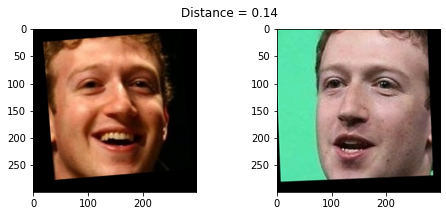

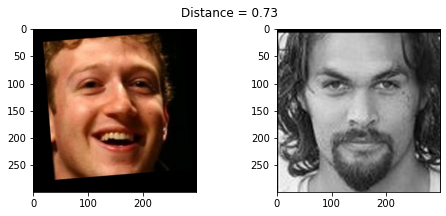

In [73]:
# show distance between multiple pairs as mentioned in the hint
print(f'image_path for index: 1 - ', metadata[1].image_path())
print(f'image_path for index: 4 - ', metadata[4].image_path())
print(f'image_path for index: 404 - ', metadata[404].image_path())
show_pair(1, 4)
show_pair(1, 404)

image_path for index: 40 -  PINS/pins_mark zuckerberg/mark zuckerberg23.jpg
image_path for index: 50 -  PINS/pins_mark zuckerberg/mark zuckerberg15.jpg
image_path for index: 444 -  PINS/pins_Jason Momoa/Jason Momoa3.jpg


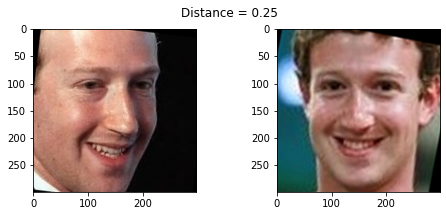

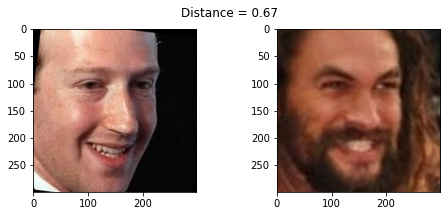

In [76]:
print(f'image_path for index: 40 - ', metadata[40].image_path())
print(f'image_path for index: 50 - ', metadata[50].image_path())
print(f'image_path for index: 444 - ', metadata[444].image_path())

show_pair(40, 50)
show_pair(40, 444)

image_path for index: 5001 -  PINS/pins_gal gadot face/gal gadot face81.jpg
image_path for index: 5003 -  PINS/pins_gal gadot face/gal gadot face145.jpg
image_path for index: 2490 -  PINS/pins_Peter Dinklage/Peter Dinklage191_178.jpg


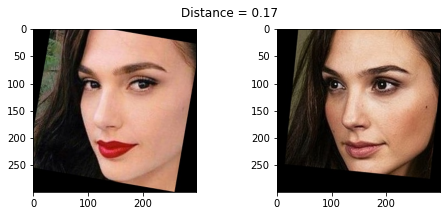

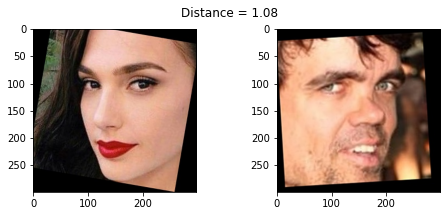

In [102]:
print(f'image_path for index: 5001 - ', metadata[5001].image_path())
print(f'image_path for index: 5003 - ', metadata[5003].image_path())
print(f'image_path for index: 2490 - ', metadata[2490].image_path())

show_pair(5003, 5001)
show_pair(5003, 2490)

In [44]:
# Get the train and test data
train_id = np.arange(metadata.shape[0]) % 9 != 0     
test_id = np.arange(metadata.shape[0]) % 9 == 0

# half of the examples as train samples for 10 identities
X_train = embeddings[train_id]

# another half of the examples as test samples for 10 identities
X_test = embeddings[test_id]
target = np.array([m.name for m in metadata])

#train labels
y_train = target[train_id]

#test labels
y_test = target[test_id]

print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [45]:
# Check a sample train and test label
y_test[10], y_train[50]

('pins_amber heard face', 'pins_mark zuckerberg')

In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [47]:
# Get the test label transformation
y_test_encoded = le.transform(y_test)

In [48]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [88 88 88 ... 96 96 96]
y_test_encoded :  [88 88 88 ... 96 96 96]


In [49]:
%%time

# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

CPU times: user 375 ms, sys: 7.01 ms, total: 382 ms
Wall time: 389 ms


In [50]:
X_test_std = scaler.transform(X_test)

In [51]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (9573,2622)
y_train_encoded shape : (9573,)
X_test_std shape : (1197,2622)
y_test_encoded shape : (1197,)


## **6. Use PCA for dimensionality reduction.**

In [52]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

CPU times: user 9.34 s, sys: 859 ms, total: 10.2 s
Wall time: 5.62 s


## **7. Build an SVM classifier in order to map each image to its right person.**

In [53]:
%%time

# Build an SVM classifier in order to map each image to its right person
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

CPU times: user 9.15 s, sys: 99 ms, total: 9.25 s
Wall time: 9.12 s


SVC(C=5.0, gamma=0.001)

In [54]:
y_predict = clf.predict(X_test_pca)

In [55]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [88 88 88 ... 96 96 96]
y_test_encoded :  [88 88 88 ... 96 96 96]


In [56]:
y_predict_encoded = le.inverse_transform(y_predict)

In [57]:
# Print the original un-encoded labels
print(y_predict_encoded)

['pins_mark zuckerberg' 'pins_mark zuckerberg' 'pins_mark zuckerberg' ...
 'pins_tati gabrielle' 'pins_tati gabrielle' 'pins_tati gabrielle']


In [58]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (1197,)
y_test_encoded shape :  (1197,)


In [59]:
# Get the accuracy score of the model on test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test_encoded, y_predict)

0.9557226399331662

## **8. Import and display the the test images.**

In [60]:
# Read the test images
actual_img1 = cv2.imread('Benedict Cumberbatch9.jpg')
actual_img2 = cv2.imread('Dwayne Johnson4.jpg')

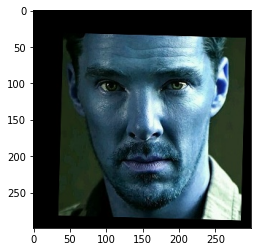

In [61]:
# Display the test images
plt.imshow(actual_img1)

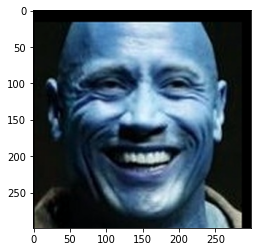

In [62]:
plt.imshow(actual_img2)

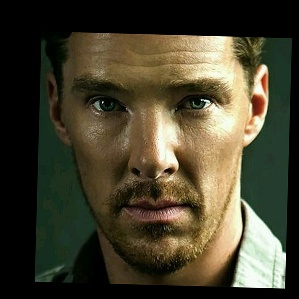

In [63]:
# display test images using cv2_imshow
cv2_imshow(actual_img1)

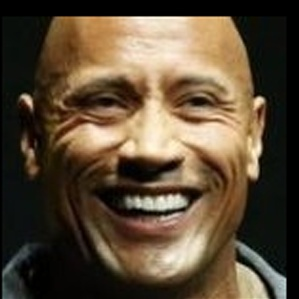

In [64]:
cv2_imshow(actual_img2)

## **9. Use the trained SVM model to predict the face on both test images.**

In [65]:
def sample_img_plot(image):
  # Load image for sample_idx from test data
  sample_img = load_image(image)
  # Get actual name
  actual_name = image
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_model.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = scaler.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = clf.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = le.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return pred_name

In [66]:
# Pass the test images to the prediction function
pred_img1 = sample_img_plot('Benedict Cumberbatch9.jpg')
pred_img2 = sample_img_plot('Dwayne Johnson4.jpg')

1/1 [==============================] - 1s 615ms/step


In [67]:
print('Benedict Cumberbatch image predicted as: ', pred_img1)
print('Dwayne Johnson image predicted as: ', pred_img2)

Benedict Cumberbatch image predicted as:  Benedict Cumberbatch
Dwayne Johnson image predicted as:  Dwayne Johnson
